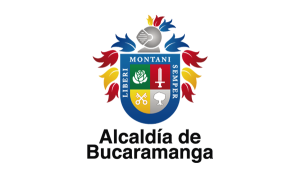

## Secretaría de Salud y Ambiente
---







<a href="https://colab.research.google.com/github/JotaRodriguez94/Forecasting_COVID_BGA/blob/main/MODELS_ML_DL_COVID-19_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

## Implementación y ajuste de modelos ML y DL para la predicción de casos COVID-19 en la ciudad de Bucaramanga.

In [1]:
#@title Importar dependencias
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'

# download the code
!git clone -q https://github.com/JotaRodriguez94/Forecasting_COVID_BGA.git
# Uncomment this block to install necessary dependencies.
#!pip install -q statsmodels
!pip install -q xgboost
!pip install -q hyperopt
!pip install -U -q keras-tuner

import gc
import tqdm
import shutil
import IPython
import imageio
import warnings
import datetime
import importlib
import numpy as np
import xgboost as xgb
import pandas as pd
import pickle as pkl
import seaborn as sns
import kerastuner as kt
import tensorflow as tf
from sklearn.svm import SVR
from sklearn import metrics
import matplotlib.pyplot as plt
from collections import defaultdict

from time import sleep
from collections import defaultdict
from IPython.core.display import display, HTML
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, STATUS_FAIL

from Forecasting_COVID_BGA import dataset, utils
from Forecasting_COVID_BGA.models.xgboost import train_xgb, optimize_xgb, optimize_direct_xgb, mape, load_direct_model

warnings.filterwarnings('once')
#importlib.reload(utils);
gpus = tf.config.experimental.list_physical_devices('GPU')
if len(gpus)>0:
    tf.config.experimental.set_memory_growth(gpus[0], True)

seed = 7
plt.style.use('ggplot')
np.random.seed(seed=seed)

fatal: destination path 'Forecasting_COVID_BGA' already exists and is not an empty directory.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Descargar los datos y procesarlos

In [2]:
#@title 
!wget -q https://www.datos.gov.co/api/views/gt2j-8ykr/rows.csv -O Casos_positivos_de_COVID-19_en_Colombia.csv
data_colombia = pd.read_csv('Casos_positivos_de_COVID-19_en_Colombia.csv')
!wget -q https://covid.ourworldindata.org/data/owid-covid-data.xlsx -O owid-covid-data.xlsx  
data = pd.read_excel('owid-covid-data.xlsx')
# preproccesing data
# preproccesing data
df_join = utils.preproccesing_data(data, data_colombia)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (14,22) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Max value in days 324


## Seleccionar los países, ciudades y departamentos a usar

In [3]:
#@title
# select the countries. cities and deps
countries_top = ['Argentina', 'Bangladesh', 'Belgium', 'Brazil', 'Canada', 'Chile', 'Czech Republic',
'France', 'Germany', 'India', 'Indonesia', 'Iran', 'Iraq', 'Israel', 'Italy', 'Mexico',
'Morocco', 'Netherlands', 'Pakistan', 'Peru', 'Philippines', 'Poland', 'Romania',
'Russia', 'Saudi Arabia', 'South Africa', 'Spain', 'Turkey', 'Ukraine', 'United Kingdom',
'United States']
dep_top = ['ANTIOQUIA', 'ATLANTICO', 'CUNDINAMARCA', 'SANTANDER', 'VALLE']
cities_top = ['BARRANQUILLA', 'BOGOTA', 'BUCARAMANGA', 'CALI', 'CARTAGENA', 'MEDELLIN']

series = cities_top + dep_top + countries_top
df_join = df_join[series]
df_join

,BARRANQUILLA,BOGOTA,BUCARAMANGA,CALI,CARTAGENA,MEDELLIN,ANTIOQUIA,ATLANTICO,CUNDINAMARCA,SANTANDER,VALLE,Argentina,Bangladesh,Belgium,Brazil,Canada,Chile,Czech Republic,France,Germany,India,Indonesia,Iran,Iraq,Israel,Italy,Mexico,Morocco,Netherlands,Pakistan,Peru,Philippines,Poland,Romania,Russia,Saudi Arabia,South Africa,Spain,Turkey,Ukraine,United Kingdom,United States
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-12-31,1.0,1.0,2.0,16.0,4.0,6.0,8.0,31.0,7.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01,1.0,1.0,2.0,16.0,4.0,6.0,8.0,31.0,7.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-02,1.0,1.0,2.0,16.0,4.0,6.0,8.0,31.0,7.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-03,1.0,1.0,2.0,16.0,4.0,6.0,8.0,31.0,7.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-04,1.0,1.0,2.0,16.0,4.0,6.0,8.0,31.0,7.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-14,5.0,11.0,2.0,9.0,1.0,30.0,59.0,3.0,6.0,14.0,9.0,11859.0,1767.0,1944.0,29070.0,4741.0,1592.0,7355.0,23794.0,22461.0,44684.0,5444.0,11737.0,2690.0,536.0,40902.0,5558.0,5515.0,6086.0,2165.0,2413.0,1893.0,24051.0,9489.0,21983.0,441.0,2213.0,21371.0,3045.0,11787.0,27301.0,184813.0
2020-11-15,1.0,1.0,1.0,2.0,5.0,12.0,14.0,3.0,4.0,1.0,2.0,8468.0,1531.0,6364.0,38307.0,4613.0,1646.0,4199.0,32095.0,16947.0,41100.0,5272.0,11203.0,2419.0,765.0,37249.0,5860.0,5875.0,5903.0,2443.0,2249.0,1624.0,25571.0,9460.0,22702.0,349.0,2237.0,0.0,3116.0,12524.0,26860.0,165277.0
2020-11-16,5.0,61.0,2.0,16.0,1.0,12.0,18.0,1.0,9.0,3.0,19.0,5645.0,1837.0,5522.0,0.0,4146.0,1597.0,1887.0,27228.0,10824.0,30548.0,4106.0,12543.0,2237.0,675.0,33977.0,3269.0,4966.0,5408.0,2128.0,2112.0,1501.0,21854.0,7096.0,22572.0,305.0,1842.0,0.0,3223.0,10681.0,24962.0,132170.0


## Parámetros de entrenamiento

In [19]:
#@title
# Date range to select the series.
initial_date = datetime.datetime.strptime('2020-03-01', '%Y-%m-%d')
#final_date = datetime.datetime.strptime(df_join.loc[~df_join['BUCARAMANGA'].isna()].index.values[-1].astype(str)[:10], '%Y-%m-%d')
# Range of dates for training and testing (last window in the future plus 7 days)
train_final_date = datetime.datetime.strptime('2020-10-05', '%Y-%m-%d')
final_date = datetime.datetime.strptime('2020-10-19', '%Y-%m-%d')
#Dictionary with necessary parameters
base_dset_params = dict(batch_size=1,
                        past_window=21,
                        future_window=14,
                        shuffle_buffer=10000,
                        col_test_series=0,
                        stateful = False,
                        scale = True,
                        differentiation = False,
                        lag = 1,
                        smoothing = True,
                        smooth = 7,
                        initial_date = initial_date,
                        final_date = final_date,
                        )

name_folder = str(train_final_date).split(' ')[0]+\
                '_'+str(base_dset_params['past_window'])+\
                '_'+str(base_dset_params['future_window'])+\
                '_'+str(base_dset_params['scale'])+\
                '_'+str(base_dset_params['smoothing'])+\
                '_'+str(base_dset_params['differentiation'])

base_dset_params

{'batch_size': 1,
 'col_test_series': 0,
 'differentiation': False,
 'final_date': datetime.datetime(2020, 10, 19, 0, 0),
 'future_window': 14,
 'initial_date': datetime.datetime(2020, 3, 1, 0, 0),
 'lag': 1,
 'past_window': 21,
 'scale': True,
 'shuffle_buffer': 10000,
 'smooth': 7,
 'smoothing': True,
 'stateful': False}

## Modelos de aprendizaje de máquina (ML)

### Construir conjuntos de datos para ML

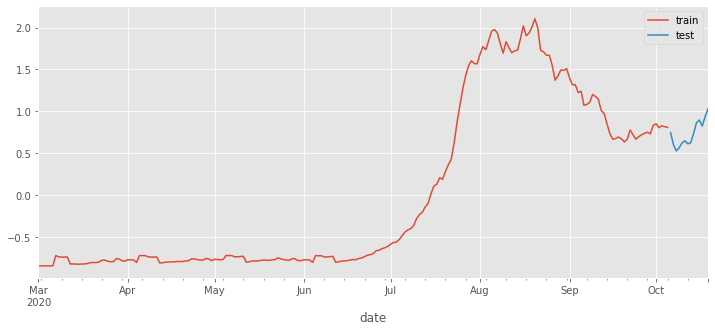

In [20]:
#@title
## select the data
final_data = df_join.loc[(df_join.index >= initial_date)
                         & (df_join.index <= final_date)]
# serie smoothing
if base_dset_params['smoothing']:
    final_data = final_data.rolling(base_dset_params['smooth']).mean().fillna(0)

# data split
final_data_train = final_data.loc[final_data.index <= train_final_date]
final_data_test = final_data.loc[final_data.index > train_final_date]
# train
bga_data_train, bga_scaler = dataset.series_transformer(
    final_data_train['BUCARAMANGA'].to_frame(),
    standarization=True,
    scaler=None)
# test
bga_data_test, bga_scaler = dataset.series_transformer(
    final_data_test['BUCARAMANGA'].to_frame(),
    standarization=True,
    scaler=bga_scaler)

ax = bga_data_train.rename(columns={'BUCARAMANGA':'train'}).plot(figsize=(12,5));
bga_data_test.rename(columns={'BUCARAMANGA':'test'}).plot(ax=ax);

## 1. Restructuración de datos para el enfoque directo

In [21]:
#@title 
ml_direct_train_dset_params = utils.copy_and_modify_dict(base_dset_params, {})
ml_direct_test_dset_params = utils.copy_and_modify_dict(base_dset_params,
                                                  {'shuffle_buffer': 0})

ml_direct_bga_dset_train = dataset.windowed_dataset(bga_data_train,
                                            ml_direct_train_dset_params,
                                            tf_dset=False,
                                            direct_dset=True)

ml_direct_bga_dset_test = dataset.windowed_dataset(bga_data_test,
                                           ml_direct_test_dset_params,
                                           tf_dset=False,
                                           direct_dset=True)

### A. SVM - Directo univariable (serie Bucaramanga)

### B. XGBoost - Directo univariable (serie Bucaramanga)

In [22]:
#@title
# hyper optimization
xgb_dir_params, xgb_dir_trials = optimize_direct_xgb(
    ml_direct_bga_dset_train['x'], ml_direct_bga_dset_train['y'], max_evals=50)

# Use the best params to train the best Direct XGBoost
xgb_dir_results = []
for idx, xgb_dir_param in enumerate(xgb_dir_params):
    xgb_dir_results.append(train_xgb(xgb_dir_param, ml_direct_bga_dset_train['x'][idx], 
                                     ml_direct_bga_dset_train['y'][idx]))
    
# Compute the Root Mean Square Error
for idx, xgb_dir_res in enumerate(xgb_dir_results):
    xgb_model_dir = xgb_dir_res["model"]
    xgb_preds_dir = xgb_model_dir.predict(ml_direct_bga_dset_test['x'][idx])
    cv_score = min([
        f["loss"] for f in xgb_dir_trials[idx].results if f["status"] == STATUS_OK
    ])
    #test_score = mape(ml_direct_bga_dset_test['y'][idx], xgb_preds_dir)
    #test_score = metrics.mean_absolute_error(ml_direct_bga_dset_test['y'][idx], xgb_preds_dir)

    #print(
    #    f"Direct Model {idx + 1}: Mean absolute error cross-validation/test: {cv_score:.4f} / {test_score:.4f}"
    #)    

Optimizing XGBoosts models using a direct approach...
Finding best params for XGBoost model 0...
100%|██████████| 50/50 [00:49<00:00,  1.01it/s, best loss: 0.007040270075339544]

    Best parameters:
        learning_rate: 0.3902172397459419 
        n_estimators: 840.0
        max_depth: 2.0
        sub_sample: 0.9647136581956814
        gamma: 46.0
    
Finding best params for XGBoost model 1...
100%|██████████| 50/50 [00:47<00:00,  1.04it/s, best loss: 0.009021361448230925]

    Best parameters:
        learning_rate: 0.2210942912296101 
        n_estimators: 720.0
        max_depth: 2.0
        sub_sample: 0.9775496258343389
        gamma: 12.0
    
Finding best params for XGBoost model 2...
100%|██████████| 50/50 [00:43<00:00,  1.14it/s, best loss: 0.01306514735035184]

    Best parameters:
        learning_rate: 0.2026468267251402 
        n_estimators: 650.0
        max_depth: 5.0
        sub_sample: 0.8865865254021217
        gamma: 69.0
    
Finding best params for XGBoost mod

### Guardar el modelo y verificar su reproducibilidad

In [23]:
#@title
# save the models
path = os.path.join('Forecasting_COVID_BGA/trained_models/xgb_direct/', name_folder, '')  
os.makedirs(path, exist_ok=True)

scalerfile = path+'scaler.pkl'
pkl.dump(bga_scaler, open(scalerfile, 'wb'),  protocol=pkl.HIGHEST_PROTOCOL)

for idx, xgb_dir_res in enumerate(xgb_dir_results):
    xgb_model_dir = xgb_dir_res["model"]
    xgb_model_dir.save_model(path+'/xgb_direct_{}_model'.format(idx))
# Load and tests if all models give the same results
for idx, xgb_dir_res in enumerate(xgb_dir_results):
    # Load the trained and saved models.
    xgb_dir_test = xgb.XGBRegressor()
    xgb_dir_test.load_model(path+'/xgb_direct_{}_model'.format(idx))

    # Compare predictions
    xgb_model_dir = xgb_dir_res["model"]
    xgb_preds_dir = xgb_model_dir.predict(ml_direct_bga_dset_test['x'][idx])
    xgb_preds_test = xgb_dir_test.predict(ml_direct_bga_dset_test['x'][idx])
    print('Predictions are equal:',
          np.array_equal(xgb_preds_dir, xgb_preds_test))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: ResourceWarning: unclosed file <_io.BufferedWriter name='Forecasting_COVID_BGA/trained_models/xgb_direct/2020-10-05_21_14_True_True_False/scaler.pkl'>
  import sys


Predictions are equal: True
Predictions are equal: True
Predictions are equal: True
Predictions are equal: True
Predictions are equal: True
Predictions are equal: True
Predictions are equal: True
Predictions are equal: True
Predictions are equal: True
Predictions are equal: True
Predictions are equal: True
Predictions are equal: True
Predictions are equal: True
Predictions are equal: True


#### Cargar el modelo y gráficar las predicciones

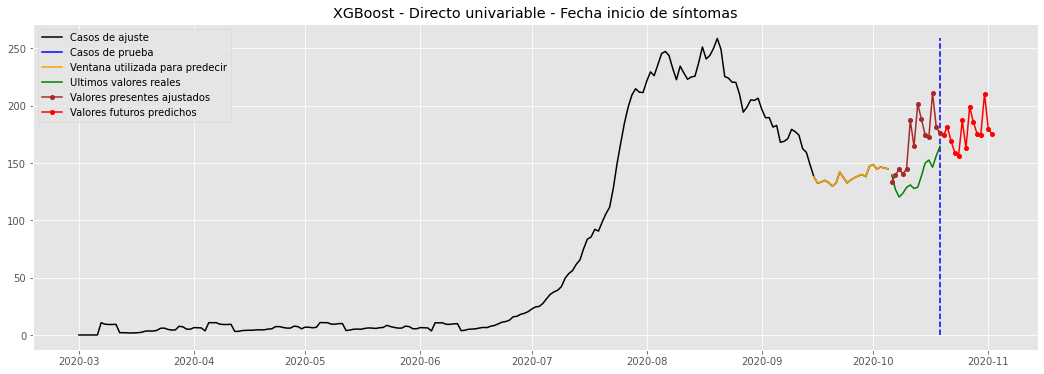

In [24]:
#@title
xgb_direct_models = load_direct_model(path)
fig_plot = utils.plot_serie_with_next_window_prediction(xgb_direct_models,
                                       final_data_train,
                                       final_data_test,
                                       bga_scaler,
                                       base_dset_params['past_window'],
                                       base_dset_params['future_window'],
                                       final_data_test.keys().values.tolist().index('BUCARAMANGA'),
                                       recursive=False,
                                       title='XGBoost - Directo univariable - Fecha inicio de síntomas')

## 2. Restructuración de datos para el enfoque recursivo

In [37]:
#@title 
ml_rec_train_dset_params = utils.copy_and_modify_dict(base_dset_params,
                                                {'future_window': 1})
ml_rec_test_dset_params = utils.copy_and_modify_dict(base_dset_params, {
    'shuffle_buffer': 0,
    'future_window': 1
})

ml_rec_bga_dset_train = dataset.windowed_dataset(bga_data_train,
                                         ml_rec_train_dset_params,
                                         tf_dset=False,
                                         direct_dset=False)

ml_rec_bga_dset_test = dataset.windowed_dataset(bga_data_test,
                                        ml_rec_test_dset_params,
                                        tf_dset=False,
                                        direct_dset=False)

### C. SVR - Recursivo univariable (serie Bucaramanga)

In [39]:
#@title
svr_rec_dir = os.path.join('Forecasting_COVID_BGA/trained_models/svr_recursive/', name_folder, '') 
#if os.path.exists(svr_rec_dir): shutil.rmtree(svr_rec_dir)
os.makedirs(svr_rec_dir, exist_ok=True)
scoring = metrics.make_scorer(metrics.mean_squared_error)

def build_model(hp):
    model = SVR(kernel=hp.Choice(
        'kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
                degree=hp.Int('degree', 1, 10, step=1),
                gamma=hp.Choice('gamma', ['scale', 'auto']),
                coef0=hp.Float('coef0', 1e-3, 1, sampling='log'),
                C=hp.Float('C', 1e-3, 1, sampling='log'),
                epsilon=hp.Float('epsilon', 1e-3, 1e-1, sampling='log'))
    return model
# optimization
tuner = kt.tuners.Sklearn(oracle=kt.oracles.BayesianOptimization(
    objective=kt.Objective('score', 'min'), max_trials=50),
                          hypermodel=build_model, directory=svr_rec_dir, scoring=scoring,
                          project_name='svr_tuner'
                          )

tuner.search(ml_rec_bga_dset_train['x'], ml_rec_bga_dset_train['y'])
## get the best model
best_model = tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
#svr_preds_rec = best_model.predict(ml_rec_bga_dset_test['x'])
# evaluate
#test_score = mape(ml_rec_bga_dset_test['y'], svr_preds_rec)
#test_score = metrics.mean_absolute_error(ml_rec_bga_dset_test['y'], svr_preds_rec)
#print(
#    f"Mean absolute error test: {test_score:.4f}"
#)

INFO:tensorflow:Oracle triggered exit


### Guardar el modelo y verificar su reproducibilidad

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: ResourceWarning: unclosed file <_io.BufferedWriter name='Forecasting_COVID_BGA/trained_models/svr_recursive/2020-10-19_21_14_True_False_False/scaler.pkl'>
  app.launch_new_instance()


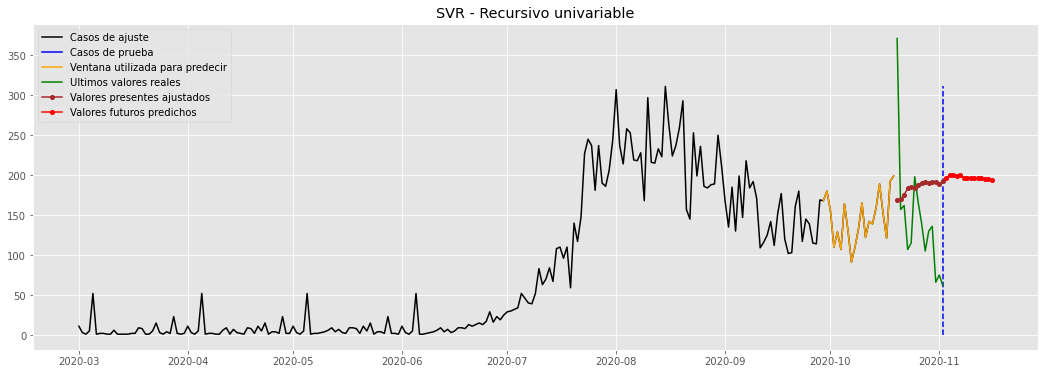

In [46]:
#@title 
#save the model
with open(svr_rec_dir+'svr_recursive_model.pkl', 'wb') as pickle_file:
    pkl.dump(best_model, pickle_file, protocol=pkl.HIGHEST_PROTOCOL)
#Load to test if it gives the same predictions    
with open(svr_rec_dir+'svr_recursive_model.pkl', 'rb') as pickle_file:
    svr_rec_test = pkl.load(pickle_file)
# test
#svr_preds_rec = best_model.predict(ml_rec_bga_dset_test['x'])
#svr_preds_test = svr_rec_test.predict(ml_rec_bga_dset_test['x'])
#test_score = metrics.mean_absolute_error(ml_rec_bga_dset_test['y'], svr_preds_test)
#print('Mean absolute error test: ', test_score)
#print('Predictions are equal:',np.array_equal(svr_preds_rec, svr_preds_test))

scalerfile = svr_rec_dir+'scaler.pkl'
pkl.dump(bga_scaler, open(scalerfile, 'wb'),  protocol=pkl.HIGHEST_PROTOCOL)

# plots
fig_plot2 = utils.plot_serie_with_next_window_prediction(svr_rec_test,
                                       final_data_train,
                                       final_data_test,
                                       bga_scaler,
                                       base_dset_params['past_window'],
                                       base_dset_params['future_window'],
                                       final_data_test.keys().values.tolist().index('BUCARAMANGA'),
                                       recursive=True,
                                       title='SVR - Recursivo univariable')

### D. XGBoost - Recursivo univariable (serie Bucaramanga)

In [47]:
#@title
xgb_rec_params, xgb_rec_trials = optimize_xgb(ml_rec_bga_dset_train['x'],
                                              ml_rec_bga_dset_train['y'],
                                              max_evals=50)

xgb_rec_res = train_xgb(xgb_rec_params, ml_rec_bga_dset_train['x'],
                        ml_rec_bga_dset_train['y'])

# Compute Mean Square Error   
xgb_model_rec = xgb_rec_res["model"]
xgb_preds_rec = xgb_model_rec.predict(ml_rec_bga_dset_test['x'])
cv_score = min(
    [f["loss"] for f in xgb_rec_trials.results if f["status"] == STATUS_OK])
#test_score = mape(ml_rec_bga_dset_test['y'], xgb_preds_rec)
test_score = metrics.mean_absolute_error(ml_rec_bga_dset_test['y'], xgb_preds_rec)
print(
    f"mean absolute error cross-validation/test: {cv_score:.4f} / {test_score:.4f}"
)

100%|██████████| 50/50 [00:43<00:00,  1.15it/s, best loss: 0.13031939590583952]

    Best parameters:
        learning_rate: 0.016527414206339585 
        n_estimators: 470.0
        max_depth: 2.0
        sub_sample: 0.8311187210630672
        gamma: 61.0
    


ValueError: ignored

### Guardar el modelo y verificar su reproducibilidad

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: ResourceWarning: unclosed file <_io.BufferedWriter name='Forecasting_COVID_BGA/trained_models/xgb_recursive/2020-10-19_21_14_True_False_False/scaler.pkl'>
  """


Predictions are equal:  True


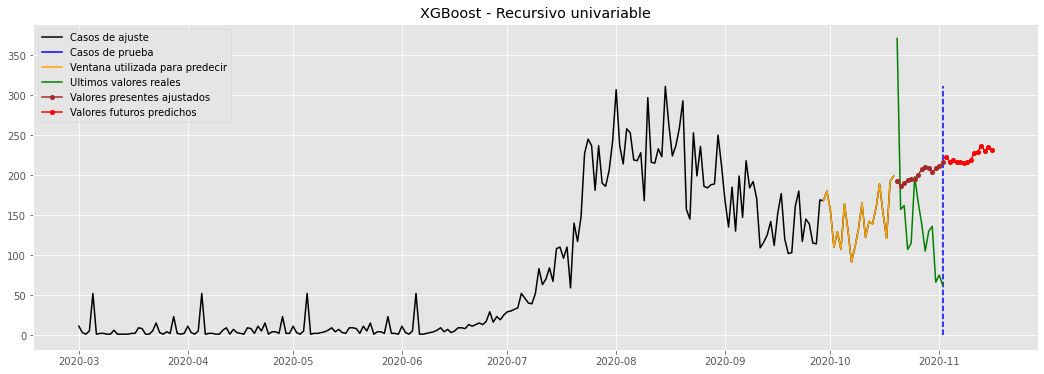

In [48]:
#@title
xgb_rec_path = os.path.join('Forecasting_COVID_BGA/trained_models/xgb_recursive/', name_folder, '') 
os.makedirs(xgb_rec_path, exist_ok=True)
scalerfile = xgb_rec_path+'scaler.pkl'
pkl.dump(bga_scaler, open(scalerfile, 'wb'),  protocol=pkl.HIGHEST_PROTOCOL)
xgb_model_rec.save_model(xgb_rec_path+'xgb_recursive_model')
#Load to test if it gives the same predictions
xgb_rec_test = xgb.XGBRegressor()
xgb_rec_test.load_model(xgb_rec_path+'xgb_recursive_model')
xgb_preds_rec = xgb_model_rec.predict(ml_rec_bga_dset_test['x'])
xgb_preds_test = xgb_rec_test.predict(ml_rec_bga_dset_test['x'])
print('Predictions are equal: ',np.array_equal(xgb_preds_rec, xgb_preds_test))
#plot
fig_plor2 = utils.plot_serie_with_next_window_prediction(xgb_rec_test,
                                       final_data_train,
                                       final_data_test,
                                       bga_scaler,
                                       base_dset_params['past_window'],
                                       base_dset_params['future_window'],
                                       final_data_test.keys().values.tolist().index('BUCARAMANGA'),
                                       recursive=True,
                                       title='XGBoost - Recursivo univariable')

## Modelos de aprendizaje profundo (DL)

## 3. Restructuración de datos para el enfoque directo univariable

In [50]:
#@title
dl_bga_dset_train = dataset.windowed_dataset(bga_data_train.values.reshape(-1,1).astype(np.float32),
                                            base_dset_params,
                                            tf_dset=True,
                                            direct_dset=None)

dl_bga_dset_test = dataset.windowed_dataset(bga_data_test.values.reshape(-1,1).astype(np.float32),
                                           base_dset_params,
                                           tf_dset=True,
                                           direct_dset=None)

In [58]:
importlib.reload(utils)

<module 'Forecasting_COVID_BGA.utils' from '/content/Forecasting_COVID_BGA/utils.py'>

### E. Modelo RNN - Directo univariable (Bucaramanga)

In [55]:
#@title
def build_standard_model(hp):
    # Extract values from dict.
    batch_size = base_dset_params['batch_size']
    window_size = base_dset_params['past_window']
    future_steps = base_dset_params['future_window']
    shuffle_buffer = base_dset_params['shuffle_buffer']
    feature_dim = base_dset_params['feature_dim']
    stateful = base_dset_params['stateful']

    # clean gpu and previous models
    tf.keras.backend.clear_session()
    gc.collect()
    # build the model
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(window_size,feature_dim), batch_size=batch_size))
    # Shape [batch, time, series] => [batch, lstm_units]
    for i in range(hp.Int('num_layers', min_value=1, max_value=3, step=1)):
        model.add(tf.keras.layers.GRU(units=hp.Choice('units_' + str(i), [16, 32, 64, 128]), 
                                      return_sequences=True, stateful=stateful))
    model.add(tf.keras.layers.GRU(units=hp.Choice('units_' + str(i+1), [16, 32, 64, 128]), 
                                   return_sequences=False, stateful=stateful))
    # Shape [batch, lstm_units] => [batch, featuresDenseDim]
    model.add(tf.keras.layers.Dense(hp.Choice('units_' + str(i+2), [16, 32, 64, 128])))
    model.add(tf.keras.layers.Dropout(hp.Float('dropout', 0, 0.5, step=0.1, default=0.5)))
    model.add(tf.keras.layers.Dense(future_steps))
    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.SGD(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]), #hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
                                                  clipvalue=hp.Choice('clipvalue', [1.0,2.0,5.0,10.0])),
                metrics=[tf.metrics.MeanAbsoluteError()])
    
    return model

# create folder
rnn_direct_dir = os.path.join('Forecasting_COVID_BGA/trained_models/rnn_direct_univariate/', name_folder, '') 
os.makedirs(rnn_direct_dir, exist_ok=True)

base_dset_params['feature_dim'] = 1
# build the tuner object for hyper opt
tuner = kt.Hyperband(
    build_standard_model,
    objective='val_mean_absolute_error',
    max_epochs=30,
    hyperband_iterations=1,
    seed=seed,
    directory=rnn_direct_dir,
    project_name='rnn_tuner'
)

# entrenar y optimizar los modelos (esta funcion es similar a fit)
tuner.search(dl_bga_dset_train,
             validation_data=dl_bga_dset_train,
             epochs=30,
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error',
                                                         patience=3,
                                                         mode='min',
                                                         restore_best_weights=True)])
best_model = tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
print(vars(best_hyperparameters))
print(best_model.evaluate(dl_bga_dset_test))

INFO:tensorflow:Reloading Oracle from existing project Forecasting_COVID_BGA/trained_models/rnn_direct_univariate/2020-10-19_21_14_True_False_False/rnn_tuner/oracle.json
Epoch 1/2
199/199 [==============================] - 5s 23ms/step - loss: 1.0405 - mean_absolute_error: 0.9012 - val_loss: 1.0391 - val_mean_absolute_error: 0.9009
Epoch 2/2
199/199 [==============================] - 4s 19ms/step - loss: 1.0372 - mean_absolute_error: 0.8996 - val_loss: 1.0384 - val_mean_absolute_error: 0.9006


Epoch 1/2
199/199 [==============================] - 3s 16ms/step - loss: 0.5011 - mean_absolute_error: 0.5512 - val_loss: 0.2836 - val_mean_absolute_error: 0.4345
Epoch 2/2
199/199 [==============================] - 2s 12ms/step - loss: 0.1728 - mean_absolute_error: 0.2872 - val_loss: 0.3767 - val_mean_absolute_error: 0.5315


Epoch 1/2
199/199 [==============================] - 6s 32ms/step - loss: 1.0210 - mean_absolute_error: 0.8919 - val_loss: 1.0156 - val_mean_absolute_error: 0.8905
Epoch 2/2
199/199 [==============================] - 5s 25ms/step - loss: 1.0193 - mean_absolute_error: 0.8910 - val_loss: 1.0146 - val_mean_absolute_error: 0.8900


Epoch 1/2
199/199 [==============================] - 4s 21ms/step - loss: 1.0212 - mean_absolute_error: 0.8945 - val_loss: 1.0207 - val_mean_absolute_error: 0.8947
Epoch 2/2
199/199 [==============================] - 3s 16ms/step - loss: 1.0224 - mean_absolute_error: 0.8950 - val_loss: 1.0207 - val_mean_absolute_error: 0.8947


Epoch 1/2
199/199 [==============================] - 4s 19ms/step - loss: 1.0441 - mean_absolute_error: 0.9050 - val_loss: 1.0437 - val_mean_absolute_error: 0.9049
Epoch 2/2
199/199 [==============================] - 3s 16ms/step - loss: 1.0433 - mean_absolute_error: 0.9047 - val_loss: 1.0429 - val_mean_absolute_error: 0.9045


Epoch 1/2
199/199 [==============================] - 4s 23ms/step - loss: 1.0722 - mean_absolute_error: 0.9111 - val_loss: 1.0661 - val_mean_absolute_error: 0.9116
Epoch 2/2
199/199 [==============================] - 4s 19ms/step - loss: 1.0714 - mean_absolute_error: 0.9107 - val_loss: 1.0660 - val_mean_absolute_error: 0.9115


Epoch 1/2
199/199 [==============================] - 3s 16ms/step - loss: 0.9685 - mean_absolute_error: 0.8649 - val_loss: 0.9651 - val_mean_absolute_error: 0.8642
Epoch 2/2
199/199 [==============================] - 2s 12ms/step - loss: 0.9674 - mean_absolute_error: 0.8644 - val_loss: 0.9650 - val_mean_absolute_error: 0.8641


Epoch 1/2
199/199 [==============================] - 3s 16ms/step - loss: 1.0264 - mean_absolute_error: 0.8959 - val_loss: 1.0203 - val_mean_absolute_error: 0.8947
Epoch 2/2
199/199 [==============================] - 3s 13ms/step - loss: 1.0162 - mean_absolute_error: 0.8911 - val_loss: 1.0108 - val_mean_absolute_error: 0.8902


Epoch 1/2
199/199 [==============================] - 4s 22ms/step - loss: 1.0487 - mean_absolute_error: 0.9060 - val_loss: 1.0379 - val_mean_absolute_error: 0.9030
Epoch 2/2
199/199 [==============================] - 4s 18ms/step - loss: 1.0276 - mean_absolute_error: 0.8964 - val_loss: 1.0170 - val_mean_absolute_error: 0.8929


Epoch 1/2
199/199 [==============================] - 4s 22ms/step - loss: 0.7260 - mean_absolute_error: 0.6827 - val_loss: 0.5343 - val_mean_absolute_error: 0.6334
Epoch 2/2
199/199 [==============================] - 3s 17ms/step - loss: 0.3199 - mean_absolute_error: 0.4240 - val_loss: 0.4765 - val_mean_absolute_error: 0.5993


Epoch 1/2
199/199 [==============================] - 6s 29ms/step - loss: 1.0302 - mean_absolute_error: 0.8979 - val_loss: 1.0278 - val_mean_absolute_error: 0.8981
Epoch 2/2
199/199 [==============================] - 5s 23ms/step - loss: 1.0255 - mean_absolute_error: 0.8961 - val_loss: 1.0227 - val_mean_absolute_error: 0.8957


Epoch 1/2
199/199 [==============================] - 3s 17ms/step - loss: 1.0509 - mean_absolute_error: 0.9023 - val_loss: 1.0113 - val_mean_absolute_error: 0.8915
Epoch 2/2
199/199 [==============================] - 3s 14ms/step - loss: 0.9783 - mean_absolute_error: 0.8673 - val_loss: 0.9387 - val_mean_absolute_error: 0.8552


Epoch 1/2
199/199 [==============================] - 6s 30ms/step - loss: 1.0406 - mean_absolute_error: 0.9030 - val_loss: 1.0417 - val_mean_absolute_error: 0.9043
Epoch 2/2
199/199 [==============================] - 5s 24ms/step - loss: 1.0418 - mean_absolute_error: 0.9041 - val_loss: 1.0417 - val_mean_absolute_error: 0.9043


Epoch 1/2
199/199 [==============================] - 4s 21ms/step - loss: 1.0556 - mean_absolute_error: 0.9009 - val_loss: 1.0289 - val_mean_absolute_error: 0.8981
Epoch 2/2
199/199 [==============================] - 3s 16ms/step - loss: 1.0197 - mean_absolute_error: 0.8876 - val_loss: 1.0012 - val_mean_absolute_error: 0.8858


Epoch 1/2
199/199 [==============================] - 5s 26ms/step - loss: 1.0225 - mean_absolute_error: 0.8945 - val_loss: 1.0217 - val_mean_absolute_error: 0.8943
Epoch 2/2
199/199 [==============================] - 4s 21ms/step - loss: 1.0213 - mean_absolute_error: 0.8940 - val_loss: 1.0205 - val_mean_absolute_error: 0.8938


Epoch 1/2
199/199 [==============================] - 3s 15ms/step - loss: 0.9612 - mean_absolute_error: 0.8525 - val_loss: 0.9229 - val_mean_absolute_error: 0.8429
Epoch 2/2
199/199 [==============================] - 2s 12ms/step - loss: 0.8993 - mean_absolute_error: 0.8190 - val_loss: 0.8582 - val_mean_absolute_error: 0.8073


Epoch 1/2
199/199 [==============================] - 5s 24ms/step - loss: 1.0789 - mean_absolute_error: 0.9231 - val_loss: 1.0804 - val_mean_absolute_error: 0.9237
Epoch 2/2
199/199 [==============================] - 4s 19ms/step - loss: 1.0833 - mean_absolute_error: 0.9243 - val_loss: 1.0792 - val_mean_absolute_error: 0.9231


Epoch 1/2
199/199 [==============================] - 5s 25ms/step - loss: 0.9969 - mean_absolute_error: 0.8833 - val_loss: 0.9959 - val_mean_absolute_error: 0.8828
Epoch 2/2
199/199 [==============================] - 4s 21ms/step - loss: 0.9962 - mean_absolute_error: 0.8827 - val_loss: 0.9958 - val_mean_absolute_error: 0.8828


Epoch 1/2
199/199 [==============================] - 3s 16ms/step - loss: 1.0893 - mean_absolute_error: 0.9203 - val_loss: 1.0682 - val_mean_absolute_error: 0.9135
Epoch 2/2
199/199 [==============================] - 2s 12ms/step - loss: 1.0470 - mean_absolute_error: 0.9024 - val_loss: 1.0341 - val_mean_absolute_error: 0.8984


Epoch 1/2
199/199 [==============================] - 6s 30ms/step - loss: 1.0349 - mean_absolute_error: 0.8945 - val_loss: 1.0228 - val_mean_absolute_error: 0.8970
Epoch 2/2
199/199 [==============================] - 5s 24ms/step - loss: 1.0113 - mean_absolute_error: 0.8837 - val_loss: 0.9990 - val_mean_absolute_error: 0.8864


Epoch 1/2
199/199 [==============================] - 3s 16ms/step - loss: 1.0399 - mean_absolute_error: 0.8956 - val_loss: 1.0005 - val_mean_absolute_error: 0.8855
Epoch 2/2
199/199 [==============================] - 3s 13ms/step - loss: 0.9627 - mean_absolute_error: 0.8600 - val_loss: 0.9245 - val_mean_absolute_error: 0.8483


Epoch 1/2
199/199 [==============================] - 5s 24ms/step - loss: 1.0413 - mean_absolute_error: 0.9047 - val_loss: 1.0412 - val_mean_absolute_error: 0.9051
Epoch 2/2
199/199 [==============================] - 4s 20ms/step - loss: 1.0417 - mean_absolute_error: 0.9049 - val_loss: 1.0412 - val_mean_absolute_error: 0.9051


Epoch 1/2
199/199 [==============================] - 3s 17ms/step - loss: 0.4926 - mean_absolute_error: 0.5354 - val_loss: 0.3699 - val_mean_absolute_error: 0.5216
Epoch 2/2
199/199 [==============================] - 3s 13ms/step - loss: 0.1876 - mean_absolute_error: 0.3135 - val_loss: 0.4457 - val_mean_absolute_error: 0.5873


Epoch 1/2
199/199 [==============================] - 5s 25ms/step - loss: 0.5377 - mean_absolute_error: 0.5673 - val_loss: 0.4956 - val_mean_absolute_error: 0.6161
Epoch 2/2
199/199 [==============================] - 4s 20ms/step - loss: 0.2552 - mean_absolute_error: 0.3752 - val_loss: 0.5718 - val_mean_absolute_error: 0.6700


Epoch 1/2
199/199 [==============================] - 4s 22ms/step - loss: 0.7388 - mean_absolute_error: 0.6824 - val_loss: 0.6006 - val_mean_absolute_error: 0.6865
Epoch 2/2
199/199 [==============================] - 3s 17ms/step - loss: 0.2334 - mean_absolute_error: 0.3592 - val_loss: 0.5083 - val_mean_absolute_error: 0.6307


Epoch 1/2
199/199 [==============================] - 6s 29ms/step - loss: 1.0060 - mean_absolute_error: 0.8771 - val_loss: 0.9859 - val_mean_absolute_error: 0.8801
Epoch 2/2
199/199 [==============================] - 5s 23ms/step - loss: 0.9568 - mean_absolute_error: 0.8545 - val_loss: 0.9294 - val_mean_absolute_error: 0.8533


Epoch 1/2
199/199 [==============================] - 4s 22ms/step - loss: 1.0106 - mean_absolute_error: 0.8879 - val_loss: 1.0089 - val_mean_absolute_error: 0.8880
Epoch 2/2
199/199 [==============================] - 4s 18ms/step - loss: 1.0094 - mean_absolute_error: 0.8870 - val_loss: 1.0040 - val_mean_absolute_error: 0.8857


Epoch 1/2
199/199 [==============================] - 8s 40ms/step - loss: 1.0290 - mean_absolute_error: 0.8982 - val_loss: 1.0274 - val_mean_absolute_error: 0.8978
Epoch 2/2
199/199 [==============================] - 6s 29ms/step - loss: 1.0265 - mean_absolute_error: 0.8970 - val_loss: 1.0265 - val_mean_absolute_error: 0.8974


Epoch 1/2
199/199 [==============================] - 3s 17ms/step - loss: 0.9926 - mean_absolute_error: 0.8706 - val_loss: 0.9451 - val_mean_absolute_error: 0.8542
Epoch 2/2
199/199 [==============================] - 3s 15ms/step - loss: 0.8988 - mean_absolute_error: 0.8209 - val_loss: 0.8520 - val_mean_absolute_error: 0.8022


Epoch 1/2
199/199 [==============================] - 5s 23ms/step - loss: 0.6023 - mean_absolute_error: 0.6113 - val_loss: 0.4745 - val_mean_absolute_error: 0.6006
Epoch 2/2
199/199 [==============================] - 4s 19ms/step - loss: 0.2237 - mean_absolute_error: 0.3490 - val_loss: 0.5633 - val_mean_absolute_error: 0.6646


Epoch 1/2
199/199 [==============================] - 3s 15ms/step - loss: 1.1518 - mean_absolute_error: 0.9512 - val_loss: 1.1310 - val_mean_absolute_error: 0.9474
Epoch 2/2
199/199 [==============================] - 2s 12ms/step - loss: 1.1311 - mean_absolute_error: 0.9435 - val_loss: 1.1173 - val_mean_absolute_error: 0.9412


Epoch 1/2
199/199 [==============================] - 5s 23ms/step - loss: 1.0633 - mean_absolute_error: 0.9137 - val_loss: 1.0610 - val_mean_absolute_error: 0.9137
Epoch 2/2
199/199 [==============================] - 3s 17ms/step - loss: 1.0591 - mean_absolute_error: 0.9125 - val_loss: 1.0609 - val_mean_absolute_error: 0.9137


Epoch 1/2
199/199 [==============================] - 5s 25ms/step - loss: 0.5577 - mean_absolute_error: 0.5791 - val_loss: 0.5327 - val_mean_absolute_error: 0.6381
Epoch 2/2
199/199 [==============================] - 4s 19ms/step - loss: 0.2963 - mean_absolute_error: 0.4115 - val_loss: 0.6617 - val_mean_absolute_error: 0.7203


Epoch 1/2
199/199 [==============================] - 5s 26ms/step - loss: 1.0353 - mean_absolute_error: 0.8954 - val_loss: 1.0120 - val_mean_absolute_error: 0.8915
Epoch 2/2
199/199 [==============================] - 4s 22ms/step - loss: 0.9878 - mean_absolute_error: 0.8738 - val_loss: 0.9643 - val_mean_absolute_error: 0.8687


Epoch 3/4
199/199 [==============================] - 3s 16ms/step - loss: 0.5983 - mean_absolute_error: 0.6091 - val_loss: 0.3557 - val_mean_absolute_error: 0.5102
Epoch 4/4
199/199 [==============================] - 3s 13ms/step - loss: 0.1756 - mean_absolute_error: 0.2979 - val_loss: 0.4078 - val_mean_absolute_error: 0.5574


Epoch 3/4
199/199 [==============================] - 3s 17ms/step - loss: 0.6016 - mean_absolute_error: 0.6143 - val_loss: 0.3782 - val_mean_absolute_error: 0.5294
Epoch 4/4
199/199 [==============================] - 3s 14ms/step - loss: 0.1942 - mean_absolute_error: 0.3202 - val_loss: 0.4431 - val_mean_absolute_error: 0.5831


Epoch 3/4
199/199 [==============================] - 4s 22ms/step - loss: 0.8806 - mean_absolute_error: 0.7731 - val_loss: 0.8088 - val_mean_absolute_error: 0.7985
Epoch 4/4
199/199 [==============================] - 3s 17ms/step - loss: 0.4609 - mean_absolute_error: 0.5385 - val_loss: 0.5397 - val_mean_absolute_error: 0.6406


Epoch 3/4
199/199 [==============================] - 5s 23ms/step - loss: 0.6292 - mean_absolute_error: 0.6190 - val_loss: 0.5304 - val_mean_absolute_error: 0.6401
Epoch 4/4
199/199 [==============================] - 4s 19ms/step - loss: 0.2412 - mean_absolute_error: 0.3658 - val_loss: 0.6230 - val_mean_absolute_error: 0.6998


Epoch 3/4
199/199 [==============================] - 5s 24ms/step - loss: 0.4960 - mean_absolute_error: 0.5409 - val_loss: 0.5763 - val_mean_absolute_error: 0.6677
Epoch 4/4
199/199 [==============================] - 4s 20ms/step - loss: 0.2403 - mean_absolute_error: 0.3676 - val_loss: 0.6263 - val_mean_absolute_error: 0.7018


Epoch 3/4
199/199 [==============================] - 4s 22ms/step - loss: 0.5744 - mean_absolute_error: 0.5975 - val_loss: 0.4573 - val_mean_absolute_error: 0.5891
Epoch 4/4
199/199 [==============================] - 3s 17ms/step - loss: 0.2090 - mean_absolute_error: 0.3305 - val_loss: 0.5354 - val_mean_absolute_error: 0.6481


Epoch 3/4
199/199 [==============================] - 5s 24ms/step - loss: 0.6116 - mean_absolute_error: 0.6160 - val_loss: 0.6853 - val_mean_absolute_error: 0.7286
Epoch 4/4
199/199 [==============================] - 4s 19ms/step - loss: 0.3382 - mean_absolute_error: 0.4424 - val_loss: 0.6732 - val_mean_absolute_error: 0.7268


Epoch 3/4
199/199 [==============================] - 4s 18ms/step - loss: 0.9366 - mean_absolute_error: 0.8395 - val_loss: 0.8441 - val_mean_absolute_error: 0.8042
Epoch 4/4
199/199 [==============================] - 3s 15ms/step - loss: 0.7548 - mean_absolute_error: 0.7402 - val_loss: 0.6668 - val_mean_absolute_error: 0.6980


Epoch 3/4
199/199 [==============================] - 3s 15ms/step - loss: 1.0254 - mean_absolute_error: 0.8762 - val_loss: 0.9838 - val_mean_absolute_error: 0.8640
Epoch 4/4
199/199 [==============================] - 2s 12ms/step - loss: 0.9653 - mean_absolute_error: 0.8450 - val_loss: 0.9225 - val_mean_absolute_error: 0.8333


Epoch 3/4
199/199 [==============================] - 3s 15ms/step - loss: 1.0000 - mean_absolute_error: 0.8773 - val_loss: 0.9634 - val_mean_absolute_error: 0.8675
Epoch 4/4
199/199 [==============================] - 3s 13ms/step - loss: 0.9261 - mean_absolute_error: 0.8392 - val_loss: 0.8855 - val_mean_absolute_error: 0.8268


Epoch 3/4
199/199 [==============================] - 6s 29ms/step - loss: 1.0432 - mean_absolute_error: 0.8944 - val_loss: 1.0195 - val_mean_absolute_error: 0.8972
Epoch 4/4
199/199 [==============================] - 5s 23ms/step - loss: 0.9933 - mean_absolute_error: 0.8728 - val_loss: 0.9695 - val_mean_absolute_error: 0.8741


Epoch 3/4
199/199 [==============================] - 4s 18ms/step - loss: 1.0445 - mean_absolute_error: 0.8968 - val_loss: 1.0028 - val_mean_absolute_error: 0.8858
Epoch 4/4
199/199 [==============================] - 3s 14ms/step - loss: 0.9731 - mean_absolute_error: 0.8617 - val_loss: 0.9335 - val_mean_absolute_error: 0.8512


Epoch 5/10
199/199 [==============================] - 3s 16ms/step - loss: 0.4773 - mean_absolute_error: 0.5329 - val_loss: 0.3309 - val_mean_absolute_error: 0.4832
Epoch 6/10
199/199 [==============================] - 3s 13ms/step - loss: 0.1735 - mean_absolute_error: 0.2909 - val_loss: 0.4157 - val_mean_absolute_error: 0.5622
Epoch 7/10
199/199 [==============================] - 3s 13ms/step - loss: 0.1852 - mean_absolute_error: 0.3115 - val_loss: 0.4070 - val_mean_absolute_error: 0.5553
Epoch 8/10
199/199 [==============================] - 3s 13ms/step - loss: 0.1819 - mean_absolute_error: 0.3088 - val_loss: 0.3910 - val_mean_absolute_error: 0.5424


Epoch 5/10
199/199 [==============================] - 3s 17ms/step - loss: 0.5770 - mean_absolute_error: 0.5970 - val_loss: 0.3411 - val_mean_absolute_error: 0.4943
Epoch 6/10
199/199 [==============================] - 3s 14ms/step - loss: 0.1943 - mean_absolute_error: 0.3173 - val_loss: 0.3839 - val_mean_absolute_error: 0.5408
Epoch 7/10
199/199 [==============================] - 3s 15ms/step - loss: 0.1962 - mean_absolute_error: 0.3235 - val_loss: 0.3915 - val_mean_absolute_error: 0.5465
Epoch 8/10
199/199 [==============================] - 3s 14ms/step - loss: 0.1913 - mean_absolute_error: 0.3175 - val_loss: 0.3777 - val_mean_absolute_error: 0.5361


Epoch 5/10
199/199 [==============================] - 4s 23ms/step - loss: 0.6000 - mean_absolute_error: 0.6173 - val_loss: 0.4081 - val_mean_absolute_error: 0.5501
Epoch 6/10
199/199 [==============================] - 3s 18ms/step - loss: 0.1937 - mean_absolute_error: 0.3199 - val_loss: 0.5401 - val_mean_absolute_error: 0.6525
Epoch 7/10
199/199 [==============================] - 3s 17ms/step - loss: 0.2036 - mean_absolute_error: 0.3273 - val_loss: 0.5136 - val_mean_absolute_error: 0.6351
Epoch 8/10
199/199 [==============================] - 3s 18ms/step - loss: 0.1976 - mean_absolute_error: 0.3255 - val_loss: 0.5021 - val_mean_absolute_error: 0.6258


Epoch 5/10
199/199 [==============================] - 5s 24ms/step - loss: 0.6648 - mean_absolute_error: 0.6466 - val_loss: 0.4724 - val_mean_absolute_error: 0.5984
Epoch 6/10
199/199 [==============================] - 4s 19ms/step - loss: 0.2242 - mean_absolute_error: 0.3532 - val_loss: 0.6010 - val_mean_absolute_error: 0.6894
Epoch 7/10
199/199 [==============================] - 4s 19ms/step - loss: 0.2308 - mean_absolute_error: 0.3559 - val_loss: 0.6007 - val_mean_absolute_error: 0.6879
Epoch 8/10
199/199 [==============================] - 4s 19ms/step - loss: 0.2189 - mean_absolute_error: 0.3436 - val_loss: 0.5882 - val_mean_absolute_error: 0.6829


Epoch 11/30
199/199 [==============================] - 3s 16ms/step - loss: 0.5535 - mean_absolute_error: 0.5790 - val_loss: 0.3371 - val_mean_absolute_error: 0.4909
Epoch 12/30
199/199 [==============================] - 3s 13ms/step - loss: 0.1811 - mean_absolute_error: 0.3012 - val_loss: 0.3802 - val_mean_absolute_error: 0.5345
Epoch 13/30
199/199 [==============================] - 3s 13ms/step - loss: 0.1837 - mean_absolute_error: 0.3075 - val_loss: 0.3825 - val_mean_absolute_error: 0.5360
Epoch 14/30
199/199 [==============================] - 3s 13ms/step - loss: 0.1848 - mean_absolute_error: 0.3083 - val_loss: 0.3768 - val_mean_absolute_error: 0.5306


Epoch 11/30
199/199 [==============================] - 3s 17ms/step - loss: 0.6169 - mean_absolute_error: 0.6254 - val_loss: 0.3642 - val_mean_absolute_error: 0.5142
Epoch 12/30
199/199 [==============================] - 3s 14ms/step - loss: 0.1909 - mean_absolute_error: 0.3185 - val_loss: 0.4069 - val_mean_absolute_error: 0.5588
Epoch 13/30
199/199 [==============================] - 3s 14ms/step - loss: 0.1951 - mean_absolute_error: 0.3236 - val_loss: 0.3994 - val_mean_absolute_error: 0.5514
Epoch 14/30
199/199 [==============================] - 3s 14ms/step - loss: 0.1907 - mean_absolute_error: 0.3173 - val_loss: 0.3910 - val_mean_absolute_error: 0.5454


Epoch 1/4
199/199 [==============================] - 3s 16ms/step - loss: 1.0681 - mean_absolute_error: 0.9053 - val_loss: 1.0175 - val_mean_absolute_error: 0.8930
Epoch 2/4
199/199 [==============================] - 3s 13ms/step - loss: 0.9768 - mean_absolute_error: 0.8608 - val_loss: 0.9262 - val_mean_absolute_error: 0.8478
Epoch 3/4
199/199 [==============================] - 2s 12ms/step - loss: 0.8905 - mean_absolute_error: 0.8164 - val_loss: 0.8290 - val_mean_absolute_error: 0.7952
Epoch 4/4
199/199 [==============================] - 2s 12ms/step - loss: 0.7779 - mean_absolute_error: 0.7527 - val_loss: 0.7121 - val_mean_absolute_error: 0.7264


Epoch 1/4
199/199 [==============================] - 5s 24ms/step - loss: 0.6170 - mean_absolute_error: 0.6188 - val_loss: 0.6836 - val_mean_absolute_error: 0.7277
Epoch 2/4
199/199 [==============================] - 4s 19ms/step - loss: 0.3254 - mean_absolute_error: 0.4364 - val_loss: 0.6379 - val_mean_absolute_error: 0.7036
Epoch 3/4
199/199 [==============================] - 4s 19ms/step - loss: 0.2820 - mean_absolute_error: 0.4008 - val_loss: 0.6463 - val_mean_absolute_error: 0.7103
Epoch 4/4
199/199 [==============================] - 4s 20ms/step - loss: 0.2839 - mean_absolute_error: 0.3996 - val_loss: 0.6547 - val_mean_absolute_error: 0.7157


Epoch 1/4
199/199 [==============================] - 6s 30ms/step - loss: 1.0358 - mean_absolute_error: 0.8919 - val_loss: 1.0221 - val_mean_absolute_error: 0.8974
Epoch 2/4
199/199 [==============================] - 5s 24ms/step - loss: 1.0082 - mean_absolute_error: 0.8801 - val_loss: 0.9915 - val_mean_absolute_error: 0.8832
Epoch 3/4
199/199 [==============================] - 5s 24ms/step - loss: 0.9735 - mean_absolute_error: 0.8618 - val_loss: 0.9525 - val_mean_absolute_error: 0.8630
Epoch 4/4
199/199 [==============================] - 5s 24ms/step - loss: 0.9266 - mean_absolute_error: 0.8366 - val_loss: 0.8964 - val_mean_absolute_error: 0.8323


Epoch 1/4
199/199 [==============================] - 3s 15ms/step - loss: 1.0155 - mean_absolute_error: 0.8862 - val_loss: 1.0097 - val_mean_absolute_error: 0.8855
Epoch 2/4
199/199 [==============================] - 2s 12ms/step - loss: 1.0096 - mean_absolute_error: 0.8837 - val_loss: 1.0097 - val_mean_absolute_error: 0.8855
Epoch 3/4
199/199 [==============================] - 2s 12ms/step - loss: 1.0097 - mean_absolute_error: 0.8833 - val_loss: 1.0096 - val_mean_absolute_error: 0.8855
Epoch 4/4
199/199 [==============================] - 2s 12ms/step - loss: 1.0136 - mean_absolute_error: 0.8851 - val_loss: 1.0095 - val_mean_absolute_error: 0.8854


Epoch 1/4
199/199 [==============================] - 6s 30ms/step - loss: 1.0442 - mean_absolute_error: 0.9035 - val_loss: 1.0380 - val_mean_absolute_error: 0.9024
Epoch 2/4
199/199 [==============================] - 5s 24ms/step - loss: 1.0363 - mean_absolute_error: 0.9008 - val_loss: 1.0331 - val_mean_absolute_error: 0.9000
Epoch 3/4
199/199 [==============================] - 5s 24ms/step - loss: 1.0335 - mean_absolute_error: 0.8986 - val_loss: 1.0282 - val_mean_absolute_error: 0.8976
Epoch 4/4
199/199 [==============================] - 5s 24ms/step - loss: 1.0267 - mean_absolute_error: 0.8953 - val_loss: 1.0233 - val_mean_absolute_error: 0.8951


Epoch 1/4
199/199 [==============================] - 3s 15ms/step - loss: 0.7214 - mean_absolute_error: 0.6888 - val_loss: 0.5393 - val_mean_absolute_error: 0.6390
Epoch 2/4
199/199 [==============================] - 2s 12ms/step - loss: 0.3494 - mean_absolute_error: 0.4516 - val_loss: 0.4952 - val_mean_absolute_error: 0.6130
Epoch 3/4
199/199 [==============================] - 2s 12ms/step - loss: 0.2799 - mean_absolute_error: 0.4004 - val_loss: 0.5436 - val_mean_absolute_error: 0.6499
Epoch 4/4
199/199 [==============================] - 2s 12ms/step - loss: 0.2734 - mean_absolute_error: 0.3921 - val_loss: 0.5380 - val_mean_absolute_error: 0.6456


Epoch 1/4
199/199 [==============================] - 6s 28ms/step - loss: 1.0603 - mean_absolute_error: 0.9143 - val_loss: 1.0602 - val_mean_absolute_error: 0.9143
Epoch 2/4
199/199 [==============================] - 4s 22ms/step - loss: 1.0601 - mean_absolute_error: 0.9142 - val_loss: 1.0599 - val_mean_absolute_error: 0.9142
Epoch 3/4
199/199 [==============================] - 4s 22ms/step - loss: 1.0598 - mean_absolute_error: 0.9141 - val_loss: 1.0597 - val_mean_absolute_error: 0.9141
Epoch 4/4
199/199 [==============================] - 4s 22ms/step - loss: 1.0596 - mean_absolute_error: 0.9139 - val_loss: 1.0594 - val_mean_absolute_error: 0.9140


Epoch 1/4
199/199 [==============================] - 3s 15ms/step - loss: 1.0588 - mean_absolute_error: 0.9028 - val_loss: 1.0122 - val_mean_absolute_error: 0.8904
Epoch 2/4
199/199 [==============================] - 2s 12ms/step - loss: 0.9803 - mean_absolute_error: 0.8643 - val_loss: 0.9364 - val_mean_absolute_error: 0.8517
Epoch 3/4
199/199 [==============================] - 2s 11ms/step - loss: 0.9024 - mean_absolute_error: 0.8220 - val_loss: 0.8594 - val_mean_absolute_error: 0.8093
Epoch 4/4
199/199 [==============================] - 2s 11ms/step - loss: 0.8224 - mean_absolute_error: 0.7781 - val_loss: 0.7776 - val_mean_absolute_error: 0.7621


Epoch 1/4
199/199 [==============================] - 5s 25ms/step - loss: 1.0465 - mean_absolute_error: 0.9042 - val_loss: 1.0444 - val_mean_absolute_error: 0.9057
Epoch 2/4
199/199 [==============================] - 4s 21ms/step - loss: 1.0509 - mean_absolute_error: 0.9069 - val_loss: 1.0443 - val_mean_absolute_error: 0.9057
Epoch 3/4
199/199 [==============================] - 4s 20ms/step - loss: 1.0452 - mean_absolute_error: 0.9049 - val_loss: 1.0442 - val_mean_absolute_error: 0.9056
Epoch 4/4
199/199 [==============================] - 4s 20ms/step - loss: 1.0445 - mean_absolute_error: 0.9044 - val_loss: 1.0441 - val_mean_absolute_error: 0.9056


Epoch 1/4
199/199 [==============================] - 5s 26ms/step - loss: 1.0956 - mean_absolute_error: 0.9228 - val_loss: 1.0822 - val_mean_absolute_error: 0.9217
Epoch 2/4
199/199 [==============================] - 4s 22ms/step - loss: 1.0826 - mean_absolute_error: 0.9183 - val_loss: 1.0712 - val_mean_absolute_error: 0.9170
Epoch 3/4
199/199 [==============================] - 4s 22ms/step - loss: 1.0693 - mean_absolute_error: 0.9133 - val_loss: 1.0612 - val_mean_absolute_error: 0.9125
Epoch 4/4
199/199 [==============================] - 4s 22ms/step - loss: 1.0589 - mean_absolute_error: 0.9089 - val_loss: 1.0521 - val_mean_absolute_error: 0.9084


Epoch 1/4
199/199 [==============================] - 3s 17ms/step - loss: 0.5555 - mean_absolute_error: 0.5781 - val_loss: 0.3380 - val_mean_absolute_error: 0.4928
Epoch 2/4
199/199 [==============================] - 3s 14ms/step - loss: 0.1771 - mean_absolute_error: 0.2955 - val_loss: 0.4019 - val_mean_absolute_error: 0.5508
Epoch 3/4
199/199 [==============================] - 3s 14ms/step - loss: 0.1879 - mean_absolute_error: 0.3109 - val_loss: 0.3920 - val_mean_absolute_error: 0.5432
Epoch 4/4
199/199 [==============================] - 3s 14ms/step - loss: 0.1862 - mean_absolute_error: 0.3078 - val_loss: 0.3875 - val_mean_absolute_error: 0.5393


Epoch 1/4
199/199 [==============================] - 6s 30ms/step - loss: 1.0199 - mean_absolute_error: 0.8936 - val_loss: 1.0201 - val_mean_absolute_error: 0.8939
Epoch 2/4
199/199 [==============================] - 5s 24ms/step - loss: 1.0205 - mean_absolute_error: 0.8937 - val_loss: 1.0194 - val_mean_absolute_error: 0.8936
Epoch 3/4
199/199 [==============================] - 5s 24ms/step - loss: 1.0191 - mean_absolute_error: 0.8933 - val_loss: 1.0188 - val_mean_absolute_error: 0.8933
Epoch 4/4
199/199 [==============================] - 5s 24ms/step - loss: 1.0195 - mean_absolute_error: 0.8933 - val_loss: 1.0181 - val_mean_absolute_error: 0.8929


Epoch 1/4
199/199 [==============================] - 6s 30ms/step - loss: 1.0509 - mean_absolute_error: 0.9096 - val_loss: 1.0491 - val_mean_absolute_error: 0.9090
Epoch 2/4
199/199 [==============================] - 5s 24ms/step - loss: 1.0491 - mean_absolute_error: 0.9088 - val_loss: 1.0488 - val_mean_absolute_error: 0.9089
Epoch 3/4
199/199 [==============================] - 5s 25ms/step - loss: 1.0493 - mean_absolute_error: 0.9087 - val_loss: 1.0484 - val_mean_absolute_error: 0.9087
Epoch 4/4
199/199 [==============================] - 5s 25ms/step - loss: 1.0488 - mean_absolute_error: 0.9088 - val_loss: 1.0481 - val_mean_absolute_error: 0.9086


Epoch 1/4
199/199 [==============================] - 3s 17ms/step - loss: 1.0786 - mean_absolute_error: 0.9221 - val_loss: 1.0731 - val_mean_absolute_error: 0.9206
Epoch 2/4
199/199 [==============================] - 3s 13ms/step - loss: 1.0655 - mean_absolute_error: 0.9164 - val_loss: 1.0618 - val_mean_absolute_error: 0.9154
Epoch 3/4
199/199 [==============================] - 3s 13ms/step - loss: 1.0582 - mean_absolute_error: 0.9128 - val_loss: 1.0505 - val_mean_absolute_error: 0.9102
Epoch 4/4
199/199 [==============================] - 3s 13ms/step - loss: 1.0444 - mean_absolute_error: 0.9063 - val_loss: 1.0394 - val_mean_absolute_error: 0.9050


Epoch 1/4
199/199 [==============================] - 6s 31ms/step - loss: 0.6108 - mean_absolute_error: 0.5984 - val_loss: 0.7064 - val_mean_absolute_error: 0.7442
Epoch 2/4
199/199 [==============================] - 5s 25ms/step - loss: 0.2611 - mean_absolute_error: 0.3794 - val_loss: 0.7276 - val_mean_absolute_error: 0.7568
Epoch 3/4
199/199 [==============================] - 5s 25ms/step - loss: 0.2372 - mean_absolute_error: 0.3572 - val_loss: 0.6999 - val_mean_absolute_error: 0.7428
Epoch 4/4
199/199 [==============================] - 5s 25ms/step - loss: 0.2358 - mean_absolute_error: 0.3558 - val_loss: 0.6532 - val_mean_absolute_error: 0.7169


Epoch 5/10
199/199 [==============================] - 3s 17ms/step - loss: 0.5162 - mean_absolute_error: 0.5536 - val_loss: 0.3266 - val_mean_absolute_error: 0.4802
Epoch 6/10
199/199 [==============================] - 3s 15ms/step - loss: 0.1801 - mean_absolute_error: 0.2980 - val_loss: 0.3929 - val_mean_absolute_error: 0.5440
Epoch 7/10
199/199 [==============================] - 3s 14ms/step - loss: 0.1825 - mean_absolute_error: 0.3068 - val_loss: 0.3861 - val_mean_absolute_error: 0.5385
Epoch 8/10
199/199 [==============================] - 3s 14ms/step - loss: 0.1802 - mean_absolute_error: 0.3064 - val_loss: 0.3788 - val_mean_absolute_error: 0.5333


Epoch 5/10
199/199 [==============================] - 3s 16ms/step - loss: 0.6085 - mean_absolute_error: 0.6092 - val_loss: 0.5291 - val_mean_absolute_error: 0.6360
Epoch 6/10
199/199 [==============================] - 3s 13ms/step - loss: 0.3117 - mean_absolute_error: 0.4254 - val_loss: 0.5195 - val_mean_absolute_error: 0.6347
Epoch 7/10
199/199 [==============================] - 2s 12ms/step - loss: 0.2703 - mean_absolute_error: 0.3931 - val_loss: 0.5299 - val_mean_absolute_error: 0.6415
Epoch 8/10
199/199 [==============================] - 3s 13ms/step - loss: 0.2464 - mean_absolute_error: 0.3672 - val_loss: 0.5607 - val_mean_absolute_error: 0.6606
Epoch 9/10
199/199 [==============================] - 3s 13ms/step - loss: 0.2443 - mean_absolute_error: 0.3651 - val_loss: 0.5204 - val_mean_absolute_error: 0.6342
Epoch 10/10
199/199 [==============================] - 3s 13ms/step - loss: 0.2280 - mean_absolute_error: 0.3546 - val_loss: 0.5493 - val_mean_absolute_error: 0.6537


Epoch 5/10
199/199 [==============================] - 5s 25ms/step - loss: 0.5857 - mean_absolute_error: 0.6019 - val_loss: 0.5213 - val_mean_absolute_error: 0.6260
Epoch 6/10
199/199 [==============================] - 4s 20ms/step - loss: 0.3091 - mean_absolute_error: 0.4219 - val_loss: 0.6054 - val_mean_absolute_error: 0.6846
Epoch 7/10
199/199 [==============================] - 4s 20ms/step - loss: 0.2818 - mean_absolute_error: 0.4071 - val_loss: 0.5954 - val_mean_absolute_error: 0.6792
Epoch 8/10
199/199 [==============================] - 4s 20ms/step - loss: 0.3039 - mean_absolute_error: 0.4138 - val_loss: 0.5916 - val_mean_absolute_error: 0.6762


Epoch 5/10
199/199 [==============================] - 6s 31ms/step - loss: 0.5581 - mean_absolute_error: 0.5740 - val_loss: 0.7435 - val_mean_absolute_error: 0.7620
Epoch 6/10
199/199 [==============================] - 5s 25ms/step - loss: 0.2476 - mean_absolute_error: 0.3692 - val_loss: 0.7465 - val_mean_absolute_error: 0.7679
Epoch 7/10
199/199 [==============================] - 5s 26ms/step - loss: 0.2510 - mean_absolute_error: 0.3717 - val_loss: 0.7458 - val_mean_absolute_error: 0.7676
Epoch 8/10
199/199 [==============================] - 5s 26ms/step - loss: 0.2346 - mean_absolute_error: 0.3605 - val_loss: 0.7404 - val_mean_absolute_error: 0.7659


Epoch 5/10
199/199 [==============================] - 3s 15ms/step - loss: 1.0801 - mean_absolute_error: 0.9050 - val_loss: 0.9931 - val_mean_absolute_error: 0.8765
Epoch 6/10
199/199 [==============================] - 2s 12ms/step - loss: 0.9364 - mean_absolute_error: 0.8371 - val_loss: 0.8623 - val_mean_absolute_error: 0.8092
Epoch 7/10
199/199 [==============================] - 2s 12ms/step - loss: 0.8111 - mean_absolute_error: 0.7672 - val_loss: 0.7315 - val_mean_absolute_error: 0.7344
Epoch 8/10
199/199 [==============================] - 2s 12ms/step - loss: 0.6912 - mean_absolute_error: 0.6951 - val_loss: 0.6004 - val_mean_absolute_error: 0.6513
Epoch 9/10
199/199 [==============================] - 2s 12ms/step - loss: 0.5856 - mean_absolute_error: 0.6233 - val_loss: 0.4803 - val_mean_absolute_error: 0.5683
Epoch 10/10
199/199 [==============================] - 2s 12ms/step - loss: 0.4824 - mean_absolute_error: 0.5507 - val_loss: 0.3869 - val_mean_absolute_error: 0.4978


Epoch 11/30
199/199 [==============================] - 3s 18ms/step - loss: 0.4858 - mean_absolute_error: 0.5358 - val_loss: 0.3471 - val_mean_absolute_error: 0.5009
Epoch 12/30
199/199 [==============================] - 3s 14ms/step - loss: 0.1748 - mean_absolute_error: 0.2940 - val_loss: 0.4252 - val_mean_absolute_error: 0.5697
Epoch 13/30
199/199 [==============================] - 3s 14ms/step - loss: 0.1851 - mean_absolute_error: 0.3120 - val_loss: 0.4077 - val_mean_absolute_error: 0.5565
Epoch 14/30
199/199 [==============================] - 3s 14ms/step - loss: 0.1834 - mean_absolute_error: 0.3086 - val_loss: 0.3893 - val_mean_absolute_error: 0.5418


Epoch 11/30
199/199 [==============================] - 3s 16ms/step - loss: 1.0162 - mean_absolute_error: 0.8780 - val_loss: 0.9527 - val_mean_absolute_error: 0.8591
Epoch 12/30
199/199 [==============================] - 3s 13ms/step - loss: 0.8995 - mean_absolute_error: 0.8217 - val_loss: 0.8404 - val_mean_absolute_error: 0.8007
Epoch 13/30
199/199 [==============================] - 3s 13ms/step - loss: 0.7957 - mean_absolute_error: 0.7641 - val_loss: 0.7222 - val_mean_absolute_error: 0.7327
Epoch 14/30
199/199 [==============================] - 2s 12ms/step - loss: 0.6806 - mean_absolute_error: 0.6929 - val_loss: 0.5969 - val_mean_absolute_error: 0.6542
Epoch 15/30
199/199 [==============================] - 2s 12ms/step - loss: 0.5504 - mean_absolute_error: 0.6100 - val_loss: 0.4750 - val_mean_absolute_error: 0.5711
Epoch 16/30
199/199 [==============================] - 2s 11ms/step - loss: 0.4721 - mean_absolute_error: 0.5491 - val_loss: 0.3814 - val_mean_absolute_error: 0.5005
Epoc

Epoch 1/10
199/199 [==============================] - 5s 27ms/step - loss: 0.9998 - mean_absolute_error: 0.8722 - val_loss: 0.9376 - val_mean_absolute_error: 0.8535
Epoch 2/10
199/199 [==============================] - 5s 23ms/step - loss: 0.8765 - mean_absolute_error: 0.8075 - val_loss: 0.8132 - val_mean_absolute_error: 0.7826
Epoch 3/10
199/199 [==============================] - 5s 23ms/step - loss: 0.7539 - mean_absolute_error: 0.7343 - val_loss: 0.6829 - val_mean_absolute_error: 0.7005
Epoch 4/10
199/199 [==============================] - 5s 23ms/step - loss: 0.6229 - mean_absolute_error: 0.6467 - val_loss: 0.5561 - val_mean_absolute_error: 0.6127
Epoch 5/10
199/199 [==============================] - 5s 23ms/step - loss: 0.5087 - mean_absolute_error: 0.5637 - val_loss: 0.4496 - val_mean_absolute_error: 0.5375
Epoch 6/10
199/199 [==============================] - 5s 23ms/step - loss: 0.4384 - mean_absolute_error: 0.5105 - val_loss: 0.3746 - val_mean_absolute_error: 0.4836
Epoch 7/10

Epoch 1/10
199/199 [==============================] - 3s 16ms/step - loss: 0.5742 - mean_absolute_error: 0.5980 - val_loss: 0.4008 - val_mean_absolute_error: 0.5440
Epoch 2/10
199/199 [==============================] - 3s 13ms/step - loss: 0.2361 - mean_absolute_error: 0.3567 - val_loss: 0.4580 - val_mean_absolute_error: 0.5944
Epoch 3/10
199/199 [==============================] - 3s 13ms/step - loss: 0.2330 - mean_absolute_error: 0.3544 - val_loss: 0.4326 - val_mean_absolute_error: 0.5778
Epoch 4/10
199/199 [==============================] - 3s 13ms/step - loss: 0.2080 - mean_absolute_error: 0.3353 - val_loss: 0.4664 - val_mean_absolute_error: 0.6010


Epoch 1/10
199/199 [==============================] - 4s 22ms/step - loss: 1.0236 - mean_absolute_error: 0.8942 - val_loss: 1.0189 - val_mean_absolute_error: 0.8935
Epoch 2/10
199/199 [==============================] - 3s 17ms/step - loss: 1.0221 - mean_absolute_error: 0.8925 - val_loss: 1.0117 - val_mean_absolute_error: 0.8901
Epoch 3/10
199/199 [==============================] - 3s 17ms/step - loss: 1.0165 - mean_absolute_error: 0.8886 - val_loss: 1.0045 - val_mean_absolute_error: 0.8866
Epoch 4/10
199/199 [==============================] - 4s 18ms/step - loss: 1.0112 - mean_absolute_error: 0.8866 - val_loss: 0.9970 - val_mean_absolute_error: 0.8830
Epoch 5/10
199/199 [==============================] - 4s 18ms/step - loss: 1.0009 - mean_absolute_error: 0.8818 - val_loss: 0.9897 - val_mean_absolute_error: 0.8794
Epoch 6/10
199/199 [==============================] - 4s 18ms/step - loss: 0.9915 - mean_absolute_error: 0.8771 - val_loss: 0.9822 - val_mean_absolute_error: 0.8757
Epoch 7/10

Epoch 1/10
199/199 [==============================] - 6s 30ms/step - loss: 1.0319 - mean_absolute_error: 0.8996 - val_loss: 1.0324 - val_mean_absolute_error: 0.9007
Epoch 2/10
199/199 [==============================] - 5s 24ms/step - loss: 1.0333 - mean_absolute_error: 0.9007 - val_loss: 1.0320 - val_mean_absolute_error: 0.9005
Epoch 3/10
199/199 [==============================] - 5s 24ms/step - loss: 1.0351 - mean_absolute_error: 0.9008 - val_loss: 1.0316 - val_mean_absolute_error: 0.9004
Epoch 4/10
199/199 [==============================] - 5s 23ms/step - loss: 1.0291 - mean_absolute_error: 0.8992 - val_loss: 1.0313 - val_mean_absolute_error: 0.9002
Epoch 5/10
199/199 [==============================] - 5s 23ms/step - loss: 1.0301 - mean_absolute_error: 0.8990 - val_loss: 1.0309 - val_mean_absolute_error: 0.9000
Epoch 6/10
199/199 [==============================] - 5s 24ms/step - loss: 1.0342 - mean_absolute_error: 0.9006 - val_loss: 1.0305 - val_mean_absolute_error: 0.8999
Epoch 7/10

Epoch 1/10
199/199 [==============================] - 5s 25ms/step - loss: 0.9964 - mean_absolute_error: 0.8712 - val_loss: 0.9489 - val_mean_absolute_error: 0.8600
Epoch 2/10
199/199 [==============================] - 5s 23ms/step - loss: 0.8999 - mean_absolute_error: 0.8219 - val_loss: 0.8395 - val_mean_absolute_error: 0.8024
Epoch 3/10
199/199 [==============================] - 4s 21ms/step - loss: 0.7821 - mean_absolute_error: 0.7557 - val_loss: 0.6927 - val_mean_absolute_error: 0.7155
Epoch 4/10
199/199 [==============================] - 4s 21ms/step - loss: 0.6230 - mean_absolute_error: 0.6553 - val_loss: 0.5187 - val_mean_absolute_error: 0.6003
Epoch 5/10
199/199 [==============================] - 4s 21ms/step - loss: 0.4750 - mean_absolute_error: 0.5515 - val_loss: 0.3709 - val_mean_absolute_error: 0.4883
Epoch 6/10
199/199 [==============================] - 4s 21ms/step - loss: 0.3706 - mean_absolute_error: 0.4640 - val_loss: 0.2960 - val_mean_absolute_error: 0.4235
Epoch 7/10

Epoch 1/10
199/199 [==============================] - 6s 33ms/step - loss: 1.0315 - mean_absolute_error: 0.9006 - val_loss: 1.0324 - val_mean_absolute_error: 0.9009
Epoch 2/10
199/199 [==============================] - 5s 27ms/step - loss: 1.0340 - mean_absolute_error: 0.9014 - val_loss: 1.0323 - val_mean_absolute_error: 0.9009
Epoch 3/10
199/199 [==============================] - 5s 27ms/step - loss: 1.0342 - mean_absolute_error: 0.9013 - val_loss: 1.0323 - val_mean_absolute_error: 0.9009
Epoch 4/10
199/199 [==============================] - 5s 27ms/step - loss: 1.0320 - mean_absolute_error: 0.9005 - val_loss: 1.0323 - val_mean_absolute_error: 0.9009
Epoch 5/10
199/199 [==============================] - 6s 28ms/step - loss: 1.0331 - mean_absolute_error: 0.9011 - val_loss: 1.0322 - val_mean_absolute_error: 0.9009
Epoch 6/10
199/199 [==============================] - 5s 27ms/step - loss: 1.0337 - mean_absolute_error: 0.9011 - val_loss: 1.0322 - val_mean_absolute_error: 0.9008
Epoch 7/10

Epoch 1/10
199/199 [==============================] - 5s 25ms/step - loss: 0.9973 - mean_absolute_error: 0.8711 - val_loss: 0.9573 - val_mean_absolute_error: 0.8618
Epoch 2/10
199/199 [==============================] - 4s 20ms/step - loss: 0.9153 - mean_absolute_error: 0.8279 - val_loss: 0.8723 - val_mean_absolute_error: 0.8174
Epoch 3/10
199/199 [==============================] - 4s 20ms/step - loss: 0.8329 - mean_absolute_error: 0.7817 - val_loss: 0.7697 - val_mean_absolute_error: 0.7601
Epoch 4/10
199/199 [==============================] - 4s 20ms/step - loss: 0.7425 - mean_absolute_error: 0.7272 - val_loss: 0.6470 - val_mean_absolute_error: 0.6845
Epoch 5/10
199/199 [==============================] - 4s 20ms/step - loss: 0.6065 - mean_absolute_error: 0.6386 - val_loss: 0.5147 - val_mean_absolute_error: 0.5962
Epoch 6/10
199/199 [==============================] - 4s 20ms/step - loss: 0.4980 - mean_absolute_error: 0.5600 - val_loss: 0.4086 - val_mean_absolute_error: 0.5171
Epoch 7/10

Epoch 1/10
199/199 [==============================] - 5s 27ms/step - loss: 0.4246 - mean_absolute_error: 0.4795 - val_loss: 0.4927 - val_mean_absolute_error: 0.6138
Epoch 2/10
199/199 [==============================] - 4s 22ms/step - loss: 0.1920 - mean_absolute_error: 0.3138 - val_loss: 0.5870 - val_mean_absolute_error: 0.6778
Epoch 3/10
199/199 [==============================] - 4s 22ms/step - loss: 0.2078 - mean_absolute_error: 0.3316 - val_loss: 0.5717 - val_mean_absolute_error: 0.6688
Epoch 4/10
199/199 [==============================] - 5s 23ms/step - loss: 0.1905 - mean_absolute_error: 0.3157 - val_loss: 0.5620 - val_mean_absolute_error: 0.6628


Epoch 11/30
199/199 [==============================] - 5s 25ms/step - loss: 0.9360 - mean_absolute_error: 0.8336 - val_loss: 0.8388 - val_mean_absolute_error: 0.8014
Epoch 12/30
199/199 [==============================] - 4s 20ms/step - loss: 0.7492 - mean_absolute_error: 0.7314 - val_loss: 0.6330 - val_mean_absolute_error: 0.6798
Epoch 13/30
199/199 [==============================] - 4s 21ms/step - loss: 0.5366 - mean_absolute_error: 0.6006 - val_loss: 0.4339 - val_mean_absolute_error: 0.5423
Epoch 14/30
199/199 [==============================] - 4s 21ms/step - loss: 0.4000 - mean_absolute_error: 0.4983 - val_loss: 0.3158 - val_mean_absolute_error: 0.4456
Epoch 15/30
199/199 [==============================] - 4s 21ms/step - loss: 0.3415 - mean_absolute_error: 0.4403 - val_loss: 0.2700 - val_mean_absolute_error: 0.4037
Epoch 16/30
199/199 [==============================] - 4s 21ms/step - loss: 0.3152 - mean_absolute_error: 0.4158 - val_loss: 0.2559 - val_mean_absolute_error: 0.3903
Epoc

Epoch 11/30
199/199 [==============================] - 6s 28ms/step - loss: 1.0003 - mean_absolute_error: 0.8726 - val_loss: 0.9401 - val_mean_absolute_error: 0.8558
Epoch 12/30
199/199 [==============================] - 4s 22ms/step - loss: 0.8783 - mean_absolute_error: 0.8076 - val_loss: 0.8162 - val_mean_absolute_error: 0.7843
Epoch 13/30
199/199 [==============================] - 4s 22ms/step - loss: 0.7442 - mean_absolute_error: 0.7261 - val_loss: 0.6794 - val_mean_absolute_error: 0.6964
Epoch 14/30
199/199 [==============================] - 4s 23ms/step - loss: 0.6164 - mean_absolute_error: 0.6389 - val_loss: 0.5510 - val_mean_absolute_error: 0.6053
Epoch 15/30
199/199 [==============================] - 4s 22ms/step - loss: 0.5154 - mean_absolute_error: 0.5601 - val_loss: 0.4543 - val_mean_absolute_error: 0.5316
Epoch 16/30
199/199 [==============================] - 4s 22ms/step - loss: 0.4383 - mean_absolute_error: 0.5022 - val_loss: 0.3859 - val_mean_absolute_error: 0.4788
Epoc

Epoch 11/30
199/199 [==============================] - 5s 24ms/step - loss: 1.0120 - mean_absolute_error: 0.8767 - val_loss: 0.9460 - val_mean_absolute_error: 0.8603
Epoch 12/30
199/199 [==============================] - 4s 20ms/step - loss: 0.8825 - mean_absolute_error: 0.8110 - val_loss: 0.8196 - val_mean_absolute_error: 0.7906
Epoch 13/30
199/199 [==============================] - 4s 19ms/step - loss: 0.7478 - mean_absolute_error: 0.7328 - val_loss: 0.6805 - val_mean_absolute_error: 0.7056
Epoch 14/30
199/199 [==============================] - 4s 19ms/step - loss: 0.6275 - mean_absolute_error: 0.6543 - val_loss: 0.5462 - val_mean_absolute_error: 0.6134
Epoch 15/30
199/199 [==============================] - 4s 19ms/step - loss: 0.5049 - mean_absolute_error: 0.5647 - val_loss: 0.4330 - val_mean_absolute_error: 0.5298
Epoch 16/30
199/199 [==============================] - 4s 20ms/step - loss: 0.4460 - mean_absolute_error: 0.5194 - val_loss: 0.3608 - val_mean_absolute_error: 0.4725
Epoc

Epoch 1/30
199/199 [==============================] - 6s 32ms/step - loss: 0.6198 - mean_absolute_error: 0.6170 - val_loss: 0.7675 - val_mean_absolute_error: 0.7767
Epoch 2/30
199/199 [==============================] - 5s 26ms/step - loss: 0.3701 - mean_absolute_error: 0.4664 - val_loss: 0.7916 - val_mean_absolute_error: 0.7933
Epoch 3/30
199/199 [==============================] - 5s 26ms/step - loss: 0.3367 - mean_absolute_error: 0.4385 - val_loss: 0.7811 - val_mean_absolute_error: 0.7878
Epoch 4/30
199/199 [==============================] - 5s 27ms/step - loss: 0.2884 - mean_absolute_error: 0.4046 - val_loss: 0.7820 - val_mean_absolute_error: 0.7884


Epoch 1/30
199/199 [==============================] - 6s 30ms/step - loss: 1.0486 - mean_absolute_error: 0.9074 - val_loss: 1.0466 - val_mean_absolute_error: 0.9075
Epoch 2/30
199/199 [==============================] - 5s 24ms/step - loss: 1.0458 - mean_absolute_error: 0.9065 - val_loss: 1.0444 - val_mean_absolute_error: 0.9065
Epoch 3/30
199/199 [==============================] - 5s 24ms/step - loss: 1.0429 - mean_absolute_error: 0.9052 - val_loss: 1.0422 - val_mean_absolute_error: 0.9056
Epoch 4/30
199/199 [==============================] - 5s 24ms/step - loss: 1.0411 - mean_absolute_error: 0.9042 - val_loss: 1.0400 - val_mean_absolute_error: 0.9047
Epoch 5/30
199/199 [==============================] - 5s 24ms/step - loss: 1.0407 - mean_absolute_error: 0.9038 - val_loss: 1.0377 - val_mean_absolute_error: 0.9037
Epoch 6/30
199/199 [==============================] - 5s 24ms/step - loss: 1.0377 - mean_absolute_error: 0.9027 - val_loss: 1.0355 - val_mean_absolute_error: 0.9028
Epoch 7/30

Epoch 1/30
199/199 [==============================] - 5s 23ms/step - loss: 1.0339 - mean_absolute_error: 0.8995 - val_loss: 1.0306 - val_mean_absolute_error: 0.8992
Epoch 2/30
199/199 [==============================] - 4s 19ms/step - loss: 1.0258 - mean_absolute_error: 0.8959 - val_loss: 1.0239 - val_mean_absolute_error: 0.8960
Epoch 3/30
199/199 [==============================] - 4s 18ms/step - loss: 1.0215 - mean_absolute_error: 0.8937 - val_loss: 1.0170 - val_mean_absolute_error: 0.8928
Epoch 4/30
199/199 [==============================] - 4s 18ms/step - loss: 1.0139 - mean_absolute_error: 0.8901 - val_loss: 1.0101 - val_mean_absolute_error: 0.8895
Epoch 5/30
199/199 [==============================] - 4s 19ms/step - loss: 1.0084 - mean_absolute_error: 0.8877 - val_loss: 1.0031 - val_mean_absolute_error: 0.8862
Epoch 6/30
199/199 [==============================] - 4s 19ms/step - loss: 1.0010 - mean_absolute_error: 0.8838 - val_loss: 0.9961 - val_mean_absolute_error: 0.8828
Epoch 7/30

Epoch 1/30
199/199 [==============================] - 6s 30ms/step - loss: 0.6307 - mean_absolute_error: 0.6044 - val_loss: 0.6457 - val_mean_absolute_error: 0.7132
Epoch 2/30
199/199 [==============================] - 5s 24ms/step - loss: 0.1877 - mean_absolute_error: 0.2993 - val_loss: 0.6674 - val_mean_absolute_error: 0.7267
Epoch 3/30
199/199 [==============================] - 5s 25ms/step - loss: 0.1880 - mean_absolute_error: 0.3006 - val_loss: 0.6180 - val_mean_absolute_error: 0.6983
Epoch 4/30
199/199 [==============================] - 5s 25ms/step - loss: 0.1780 - mean_absolute_error: 0.2932 - val_loss: 0.5778 - val_mean_absolute_error: 0.6733
Epoch 5/30
199/199 [==============================] - 5s 25ms/step - loss: 0.1671 - mean_absolute_error: 0.2842 - val_loss: 0.5443 - val_mean_absolute_error: 0.6508
Epoch 6/30
199/199 [==============================] - 5s 24ms/step - loss: 0.1556 - mean_absolute_error: 0.2736 - val_loss: 0.5159 - val_mean_absolute_error: 0.6304
Epoch 7/30

Epoch 1/30
199/199 [==============================] - 4s 18ms/step - loss: 0.5747 - mean_absolute_error: 0.5983 - val_loss: 0.4259 - val_mean_absolute_error: 0.5603
Epoch 2/30
199/199 [==============================] - 3s 15ms/step - loss: 0.2791 - mean_absolute_error: 0.4020 - val_loss: 0.4407 - val_mean_absolute_error: 0.5774
Epoch 3/30
199/199 [==============================] - 3s 14ms/step - loss: 0.2474 - mean_absolute_error: 0.3684 - val_loss: 0.4515 - val_mean_absolute_error: 0.5879
Epoch 4/30
199/199 [==============================] - 3s 14ms/step - loss: 0.2519 - mean_absolute_error: 0.3747 - val_loss: 0.4604 - val_mean_absolute_error: 0.5944


INFO:tensorflow:Oracle triggered exit
{'_space': {'num_layers': Int(name: "num_layers", min_value: 1, max_value: 3, step: 1, sampling: None, default: 1), 'units_0': Choice(name: "units_0", values: [16, 32, 64, 128], ordered: True, default: 16), 'units_1': Choice(name: "units_1", values: [16, 32, 64, 128], ordered: True, default: 16), 'units_2': Choice(name: "units_2", values: [16, 32, 64, 128], ordered: True, default: 16), 'dropout': Float(name: "dropout", min_value: 0.0, max_value: 0.5, step: 0.1, sampling: None, default: 0.5), 'learning_rate': Choice(name: "learning_rate", values: [0.01, 0.001, 0.0001, 1e-05, 1e-06], ordered: True, default: 0.01), 'clipvalue': Choice(name: "clipvalue", values: [1.0, 2.0, 5.0, 10.0], ordered: True, default: 1.0), 'units_3': Choice(name: "units_3", values: [16, 32, 64, 128], ordered: True, default: 16), 'units_4': Choice(name: "units_4", values: [16, 32, 64, 128], ordered: True, default: 16)}, 'values': {'num_layers': 1, 'units_0': 16, 'units_1': 64, '

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:581: RuntimeWarning: divide by zero encountered in log10
  numdigits = int(np.log10(self.target)) + 1


OverflowError: ignored

### Guardar el modelo

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: ResourceWarning: unclosed file <_io.BufferedWriter name='Forecasting_COVID_BGA/trained_models/rnn_direct_univariate/2020-10-19_21_14_True_False_False/scaler.pkl'>
  """


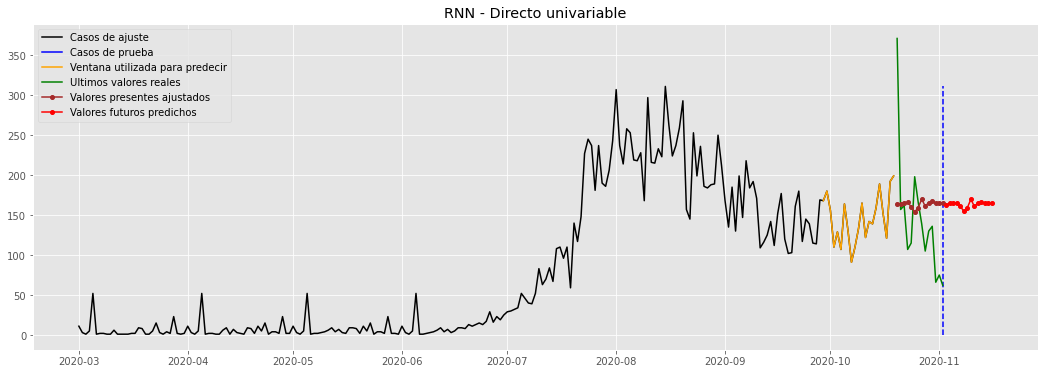

In [60]:
#@title 
#save the model
best_model.save(rnn_direct_dir+'rnn_direct_univariate_model.h5')
scalerfile = rnn_direct_dir+'scaler.pkl'
pkl.dump(bga_scaler, open(scalerfile, 'wb'),  protocol=pkl.HIGHEST_PROTOCOL)

# plots
fig_plot3 = utils.plot_serie_with_next_window_prediction(best_model,
                                       final_data_train,
                                       final_data_test,
                                       bga_scaler,
                                       base_dset_params['past_window'],
                                       base_dset_params['future_window'],
                                       final_data_test.keys().values.tolist().index('BUCARAMANGA'),
                                       recursive=True,
                                       title='RNN - Directo univariable')

In [ ]:
#!zip -r Forecasting_COVID_BGA.zip Forecasting_COVID_BGA/*

  adding: Forecasting_COVID_BGA/BGA_COVID_ML_Prediction.ipynb (deflated 40%)
  adding: Forecasting_COVID_BGA/copy_Prediccion_COVID_bga.ipynb (deflated 68%)
  adding: Forecasting_COVID_BGA/data/ (stored 0%)
  adding: Forecasting_COVID_BGA/data/owid-covid-data.xlsx (deflated 17%)
  adding: Forecasting_COVID_BGA/dataset.py (deflated 72%)
  adding: Forecasting_COVID_BGA/EDA_COVID_19_time_series.ipynb (deflated 29%)
  adding: Forecasting_COVID_BGA/html/ (stored 0%)
  adding: Forecasting_COVID_BGA/html/EDA_COVID_19_time_series.html (deflated 41%)
  adding: Forecasting_COVID_BGA/LICENSE (deflated 66%)
  adding: Forecasting_COVID_BGA/models/ (stored 0%)
  adding: Forecasting_COVID_BGA/models/.ipynb_checkpoints/ (stored 0%)
  adding: Forecasting_COVID_BGA/models/xgboost.py (deflated 66%)
  adding: Forecasting_COVID_BGA/models/__pycache__/ (stored 0%)
  adding: Forecasting_COVID_BGA/models/__pycache__/xgboost.cpython-36.pyc (deflated 47%)
  adding: Forecasting_COVID_BGA/__pycache__/ (stored 0%)
